<a href="https://colab.research.google.com/github/jjschueder/7331DataMiningNotebooks/blob/master/lab3/Agglomorative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://scikit-learn.org/stable/auto_examples/cluster/plot_inductive_clustering.html#sphx-glr-auto-examples-cluster-plot-inductive-clustering-py

In [83]:
import pandas as pd

url_dataset = 'https://raw.githubusercontent.com/jjschueder/7331DataMiningNotebooks/master/Live%20Assignments/df1hotmerge2.csv'
data = pd.read_csv(url_dataset, nrows = 30000)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 68 columns):
Unnamed: 0                  30000 non-null int64
pack                        30000 non-null int64
bottle_volume_ml            30000 non-null int64
state_bottle_cost           30000 non-null float64
state_bottle_retail         30000 non-null float64
bottles_sold                30000 non-null int64
sale_dollars                30000 non-null float64
volume_sold_liters          30000 non-null float64
volume_sold_gallons         30000 non-null float64
counter                     30000 non-null int64
liquor_category             30000 non-null object
store_parent                30000 non-null object
month                       30000 non-null object
year                        30000 non-null int64
monthyear                   30000 non-null object
liquor_category_AMARETTO    30000 non-null int64
liquor_category_BRANDY      30000 non-null int64
liquor_category_GIN         30000 non-null i

In [84]:
# Import all necessary libraries we will be using in our dataset

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import sklearn
import statistics
import random

from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, RFE, SelectFromModel

from sklearn.preprocessing import StandardScaler, Binarizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, auc, roc_curve
from IPython.display import display, HTML

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit, StratifiedShuffleSplit

from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,AdaBoostClassifier,RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


%matplotlib inline

matplotlib.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')
print(data.shape)
data.head()

(30000, 68)


,Unnamed: 0,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,liquor_category,store_parent,month,year,monthyear,liquor_category_AMARETTO,liquor_category_BRANDY,liquor_category_GIN,liquor_category_LIQUEUR,liquor_category_Other,liquor_category_RUM,liquor_category_SCHNAPPS,liquor_category_TEQUILA,liquor_category_VODKA,liquor_category_WHISKY,store_parent_CVS,store_parent_Caseys,store_parent_Hy-Vee,store_parent_Kum&Go,store_parent_Other,store_parent_QuikTrip,store_parent_SamsClub,store_parent_SmokingJoes,store_parent_Target,store_parent_Wal-Mart,store_parent_Walgreens,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,year_2019,monthyear_Apr-2019,monthyear_Aug-2019,monthyear_Dec-2019,monthyear_Feb-2019,monthyear_Jan-2019,monthyear_Jul-2019,monthyear_Jun-2019,monthyear_Mar-2019,monthyear_May-2019,monthyear_Nov-2019,monthyear_Oct-2019,monthyear_Sep-2019,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin
0,0,20,375,3.85,5.78,20,115.60,7.50,1.98,1,Other,Other,Nov,2019,Nov-19,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,4.750136,15.413333,2.735233,1.348073,2.995732,2.014903,0.333910
1,1,8,50,8.75,13.13,1,13.13,0.05,0.01,1,Other,Other,Nov,2019,Nov-19,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2.574900,262.600000,5.570632,2.169054,0.000000,-2.995732,0.333587
2,2,12,1000,16.50,24.75,6,148.50,6.00,1.58,1,GIN,Hy-Vee,May,2019,May-19,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,5.000585,24.750000,3.208825,2.803360,1.791759,1.791759,0.333333
3,3,6,750,21.17,31.76,24,762.24,18.00,4.75,1,WHISKY,Hy-Vee,Nov,2019,Nov-19,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,6.636261,42.346667,3.745890,3.052585,3.178054,2.890372,0.333438
4,4,6,1750,9.31,13.97,12,167.64,21.00,5.54,1,Other,Hy-Vee,Nov,2019,Nov-19,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,5.121819,7.982857,2.077296,2.231089,2.484907,3.044522,0.333572


In [85]:
# Since we are predicting our liquor category type (opening to the entire list of categories and not just one), we can assign them a numerical value.

print (data['liquor_category'].unique())

"""df = pd.DataFrame({'col_1':[133,255,36,477,55,63]})
d = {'1':'M', '2': 'C', '3':'a', '4':'f', '5':'r', '6':'s'}
def ifef(col):
    col = str(col)
    return d[col[0]]

df['id_label'] = df['col_1'].apply(ifef)
print(df)"""

d = {'O':'1', 'G': '2', 'W':'3', 'T':'4', 'L':'5', 'V':'6', 'R':'7', 'S': '8', 'A':'9', 'B':'10'}

#data['id_label'] = data['liquor_category'].apply(ifef)

data['id_label'] = data['liquor_category'].astype(str).str[0].map(d)

print(data.head())

['Other' 'GIN' 'WHISKY' 'TEQUILA' 'LIQUEUR' 'VODKA' 'RUM' 'SCHNAPPS'
 'AMARETTO' 'BRANDY']
   Unnamed: 0  pack  ...  grossmargin  id_label
0           0    20  ...     0.333910         1
1           1     8  ...     0.333587         1
2           2    12  ...     0.333333         2
3           3     6  ...     0.333438         3
4           4     6  ...     0.333572         1

[5 rows x 69 columns]


In [0]:
# Create new variables using aggredate data on profit, total cost and revenue

#do some calculations for cost and profit
data['profit'] = data['state_bottle_retail']*data['bottles_sold'] - data['state_bottle_cost']* data['bottles_sold']
data['profit_trans']= np.log(data['profit'])

data['totalcost'] = data['state_bottle_cost']* data['bottles_sold']
data['totalcost_trans']= np.log(data['totalcost'])

data['revenue'] = data['state_bottle_retail']*data['bottles_sold']
data['revenue_trans']= np.log(data['revenue'])

data['bottle_volume_ml_trans']= np.log(data['bottle_volume_ml'])

data['pack_trans']= np.log(data['pack'])

(30000, 11)


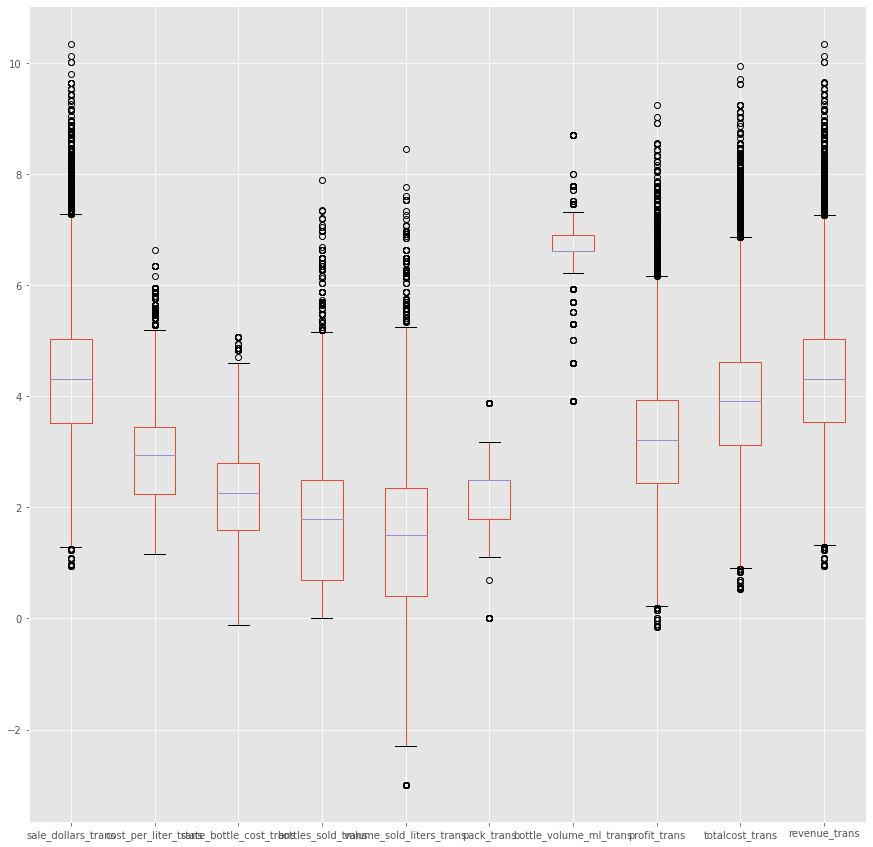

In [87]:
# Since we transformed a number of continuous variables, we can drop them so that we are working directly on our normalized data


# Remove unwanted columns, which include all the specific liquor categories, 
# except for liquor_category_WHISKY since that is what we want to classify on, along
# with all the store_ attributes
"""
cat_vars=['counter', 'liquor_category', 'store_parent',
 'month', 'year', 'monthyear', 'liquor_category_AMARETTO', 'liquor_category_BRANDY', 'liquor_category_GIN', 
 'liquor_category_LIQUEUR', 'liquor_category_Other', 'liquor_category_RUM', 'liquor_category_SCHNAPPS', 
 'liquor_category_TEQUILA', 'liquor_category_VODKA', 'month_Apr', 'month_Aug', 'month_Dec', 'month_Feb',
 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 
 'store_parent_CVS', 'store_parent_Caseys', 'store_parent_Hy-Vee', 'store_parent_Kum&Go', 
 'store_parent_Other', 'store_parent_QuikTrip', 'store_parent_SamsClub', 'store_parent_SmokingJoes', 
 'store_parent_Target', 'store_parent_Wal-Mart', 'store_parent_Walgreens']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
"""
#keep our transformed detail, along with the timing and store name detail

to_keep=['sale_dollars_trans', 'cost_per_liter_trans',
      'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans','pack_trans', 'bottle_volume_ml_trans', 
       'profit_trans', 'totalcost_trans', 'revenue_trans', 'id_label']
data_final=data[to_keep]
data_final.columns.values

#boxplot of all the variables
plt.figure(figsize=(15, 15))
ax = data_final.boxplot()
#ax.set_yscale('log')

print(data_final.shape)

In [88]:
data_final = data_final[data_final['id_label'] < "8"]
data_final = data_final[data_final['id_label'] != "10"]
data_final['id_label'].value_counts()

6    6736
3    6536
7    5515
5    4241
4    2853
1    2386
2    1716
Name: id_label, dtype: int64

In [89]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt

cv = StratifiedKFold(n_splits=10)

features = ['sale_dollars_trans', 'cost_per_liter_trans', 
       'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans', 'pack_trans', 'bottle_volume_ml_trans',
       'profit_trans', 'totalcost_trans', 'revenue_trans']

X2 = data_final[features].copy()

scaler = StandardScaler()
scaler.fit(X2)

#This makes our model's coefficients take on the same scale for accurate feature importance analysis
#Notice we scaled the data before the cross validation
X = scaler.transform(X2)

Y= data_final[['id_label']].copy()

CPU times: user 17.7 ms, sys: 0 ns, total: 17.7 ms
Wall time: 18.1 ms


In [0]:
from sklearn import metrics as mt

# train and test split before resampling
X1_train, X1_test, y1_train, y1_test = train_test_split(X, Y, test_size = 0.2, random_state = 101) 

In [91]:

print("Before OverSampling, counts of label 'Other': {}".format(sum(y1_train['id_label'] == "1")))
print("Before OverSampling, counts of label 'GIN': {} \n".format(sum(y1_train['id_label'] == "2"))) 
print("Before OverSampling, counts of label 'WHISKY': {} \n".format(sum(y1_train['id_label'] == "3"))) 
print("Before OverSampling, counts of label 'TEQUILA': {}".format(sum(y1_train['id_label'] == "4")))
print("Before OverSampling, counts of label 'LIQUEUR': {} \n".format(sum(y1_train['id_label'] == "5"))) 
print("Before OverSampling, counts of label 'VODKA': {} \n".format(sum(y1_train['id_label'] == "6"))) 
print("Before OverSampling, counts of label 'RUM': {} \n".format(sum(y1_train['id_label'] == "7"))) 


# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X1_train_res, y1_train_res = sm.fit_sample(X1_train, y1_train.values.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X1_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y1_train_res.shape)) 
  
print("After OverSampling, counts of label 'Other': {}".format(sum(y1_train_res == "1"))) 
print("After OverSampling, counts of label 'GIN': {}".format(sum(y1_train_res == "2"))) 
print("After OverSampling, counts of label 'WHISKY': {}".format(sum(y1_train_res == "3"))) 
print("After OverSampling, counts of label 'TEQUILA': {}".format(sum(y1_train_res == "4"))) 
print("After OverSampling, counts of label 'LIQUEUR': {}".format(sum(y1_train_res == "5"))) 
print("After OverSampling, counts of label 'VODKA': {}".format(sum(y1_train_res == "6"))) 
print("After OverSampling, counts of label 'RUM': {}".format(sum(y1_train_res == "7"))) 

Before OverSampling, counts of label 'Other': 1913
Before OverSampling, counts of label 'GIN': 1359 

Before OverSampling, counts of label 'WHISKY': 5232 

Before OverSampling, counts of label 'TEQUILA': 2271
Before OverSampling, counts of label 'LIQUEUR': 3383 

Before OverSampling, counts of label 'VODKA': 5413 

Before OverSampling, counts of label 'RUM': 4415 

After OverSampling, the shape of train_X: (37891, 10)
After OverSampling, the shape of train_y: (37891,) 

After OverSampling, counts of label 'Other': 5413
After OverSampling, counts of label 'GIN': 5413
After OverSampling, counts of label 'WHISKY': 5413
After OverSampling, counts of label 'TEQUILA': 5413
After OverSampling, counts of label 'LIQUEUR': 5413
After OverSampling, counts of label 'VODKA': 5413
After OverSampling, counts of label 'RUM': 5413


In [0]:
X2.columns
X1DF = pd.DataFrame(X1_train_res, columns =X2.columns)

In [93]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X1_train_res, y1_train_res)
#X_test = lda.transform(X_test)
lda.explained_variance_ratio_

array([0.80434648, 0.0950707 ])

In [94]:
X_train_lda

array([[-2.23709616, -1.42543504],
       [ 0.48613271, -0.50009817],
       [ 1.25502361, -1.0166834 ],
       ...,
       [-1.31893066,  0.03065644],
       [ 0.65404512,  0.94732615],
       [ 0.27637901,  0.24661858]])

In [0]:
X_train_ldadf=pd.DataFrame(X_train_lda)
X_train_ldadf.columns=['First Component','Second Component']

In [96]:
print(y1_train_res.shape)
ydf = pd.DataFrame(y1_train_res)

(37891,)


In [0]:
ldaydf = X_train_ldadf.merge(ydf, left_index=True, right_index=True)

In [98]:
X_train_ldadf

,First Component,Second Component
0,-2.237096,-1.425435
1,0.486133,-0.500098
2,1.255024,-1.016683
3,-1.941064,-0.350561
4,1.312689,0.335479
...,...,...
37886,0.251752,0.217263
37887,0.755187,-0.933713
37888,-1.318931,0.030656
37889,0.654045,0.947326


In [0]:
ldaydf = ldaydf.rename(columns={0: 'Liquorlabel'})

In [0]:
ldaydf1 = ldaydf.sample(n=4000)
ldaydf2 = ldaydf.sample(n=4000)

In [0]:
features = ['First Component','Second Component']

X1 = ldaydf1[features].copy()
X2 = ldaydf2[features].copy()


Y1= ldaydf1[['Liquorlabel']].copy()
Y2= ldaydf2[['Liquorlabel']].copy()

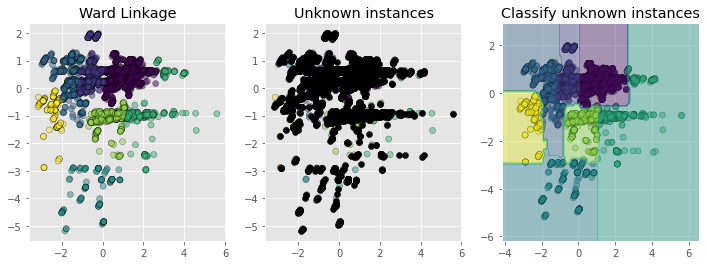

CPU times: user 1.94 s, sys: 181 ms, total: 2.12 s
Wall time: 1.92 s


In [102]:
%%time
# Authors: Chirag Nagpal
#          Christos Aridas
#print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, clone
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.metaestimators import if_delegate_has_method


N_SAMPLES = 5000
RANDOM_STATE = 42


class InductiveClusterer(BaseEstimator):
    def __init__(self, clusterer, classifier):
        self.clusterer = clusterer
        self.classifier = classifier

    def fit(self, X, y=None):
        self.clusterer_ = clone(self.clusterer)
        self.classifier_ = clone(self.classifier)
        y = self.clusterer_.fit_predict(X)
        self.classifier_.fit(X, y)
        return self

    @if_delegate_has_method(delegate='classifier_')
    def predict(self, X):
        return self.classifier_.predict(X)

    @if_delegate_has_method(delegate='classifier_')
    def decision_function(self, X):
        return self.classifier_.decision_function(X)


def plot_scatter(X,  color, alpha=0.5):
    return plt.scatter(X['First Component'],
                       X['Second Component'],
                       c=color,
                       alpha=alpha,
                       edgecolor='k')


# Generate some training data from clustering
#X, y = make_blobs(n_samples=N_SAMPLES,
#                  cluster_std=[1.0, 1.0, 0.5],
#                  centers=[(-5, -5), (0, 0), (5, 5)],
#                  random_state=RANDOM_STATE)


# Train a clustering algorithm on the training data and get the cluster labels
clusterer = AgglomerativeClustering(n_clusters=7, linkage = 'ward')
cluster_labels = clusterer.fit_predict(X1)

plt.figure(figsize=(12, 4))

plt.subplot(131)
plot_scatter(X1, cluster_labels)
plt.title("Ward Linkage")

# Generate new samples and plot them along with the original dataset
#X_new, y_new = make_blobs(n_samples=10,
#                          centers=[(-7, -1), (-2, 4), (3, 6)],
#                          random_state=RANDOM_STATE)

plt.subplot(132)
plot_scatter(X1, cluster_labels)
plot_scatter(X2, 'black', 1)
plt.title("Unknown instances")


# Declare the inductive learning model that it will be used to
# predict cluster membership for unknown instances
classifier = RandomForestClassifier(random_state=RANDOM_STATE)
inductive_learner = InductiveClusterer(clusterer, classifier).fit(X1)

probable_clusters = inductive_learner.predict(X2)


plt.subplot(133)
plot_scatter(X1, cluster_labels)
plot_scatter(X2, probable_clusters)

# Plotting decision regions
x_min, x_max = X1['First Component'].min() - 1, X1['First Component'].max() + 1
y_min, y_max = X1['Second Component'].min() - 1, X1['Second Component'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = inductive_learner.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.title("Classify unknown instances")

plt.show()

In [103]:
from google.colab import drive
drive.mount('/content/drive/')
#My Drive/ColabNotebooks/')
url_rfmodel = '/content/drive/My Drive/ColabNotebooks/rfmodelbasecluster.joblib'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
#exporting model to drive
from joblib import dump, load
#dump(clf, url_rfmodel) 

In [105]:
%%time
#importing model to new model name
clf = load(url_rfmodel)

CPU times: user 1.25 ms, sys: 9 µs, total: 1.26 ms
Wall time: 4.11 ms


In [106]:
%%time
from sklearn.model_selection import StratifiedKFold, cross_val_score
y = Y1
X = X1
X = np.column_stack((X,pd.get_dummies(cluster_labels)))

acc = cross_val_score(clf,X,y=y,cv=cv)

CPU times: user 20.4 s, sys: 117 ms, total: 20.5 s
Wall time: 20.6 s


In [107]:
print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy =  86.575 +- 1.4536591760106625


In [108]:
%%time
from sklearn.model_selection import StratifiedKFold, cross_val_score
y = Y2
X = X2
X = np.column_stack((X,pd.get_dummies(probable_clusters)))

acc = cross_val_score(clf,X,y=y,cv=cv)

CPU times: user 20.4 s, sys: 115 ms, total: 20.5 s
Wall time: 20.6 s


In [109]:
print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy =  86.175 +- 1.432000349161969
